In [2]:
!pip install datasets
!pip install tokenizers
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoids warning from tokenizer when using num_workers > 0 in DataLoader

# Encoder-only Transformer for Text Sentiment Classification

## 1. Data

### 1.1 Load the IMDB dataset

We will use the IMDB dataset for sentiment classification. The dataset consists of 50,000 movie reviews, each labeled as positive or negative. We will use 25k reviews for training, 5k for validation, and 20k for testing.

In [4]:
# Constants
SEED = 420
VAL_SIZE = 0.2

# Load IMDB dataset
dataset_train = load_dataset("imdb", split="train")
dataset_test = load_dataset("imdb", split="test")

# Split test into test and validation
dataset_test = dataset_test.train_test_split(test_size=1-VAL_SIZE, seed=SEED)
dataset_test, dataset_val = dataset_test["test"], dataset_test["train"]

print(f"Train size: {len(dataset_train)}")
print(f"Validation size: {len(dataset_val)}")
print(f"Test size: {len(dataset_test)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 25000
Validation size: 5000
Test size: 20000


### 1.2 Preprocess the data

We remove HTML tags, special characters, and convert the text to lowercase.

In [5]:
def remove_html_tags(text):
    # Remove HTML tags
    return re.sub(r'<[^>]*>', '', text)

def remove_special_characters(text):
    # Remove special characters except for ,.!? and space
    return re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)

def to_lowercase(text):
    # Convert text to lowercase
    return text.lower()

def preprocess_text(text):
    # Apply all preprocessing steps to the text
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    return text

def preprocess_batch(examples):
    # Apply preprocessing to all texts in the batch
    examples["text"] = [preprocess_text(text) for text in examples["text"]]
    return examples

# Preprocess the dataset
dataset_train = dataset_train.map(preprocess_batch, batched=True)
dataset_val = dataset_val.map(preprocess_batch, batched=True)
dataset_test = dataset_test.map(preprocess_batch, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

### 1.3 Tokenization

We use a simple word-level tokenizer to tokenize the text data. We use three special tokens: `[PAD]`, `[UNK]` and `[CLS]`. The `[PAD]` token will be used to pad the input sequences to the same length. The `[UNK]` token is used to represent out-of-vocabulary words (rare words). When classifying text, we will prepend the `[CLS]` token to the input sequence and use its output as the representation of the whole sequence.

To reduce the vocabulary size, we only keep words appearing at least `MIN_FREQUENCY` times in the training set.

In [6]:
# Special tokens (padding, unknown, classification)
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
CLS_TOKEN = "[CLS]"
MIN_FREQUENCY = 10
VOCAB_SIZE = 10000

# Tokenizer setup
tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
tokenizer.pre_tokenizer = Whitespace() # Split on whitespace

# Train tokenizer on the training set
trainer = WordLevelTrainer(special_tokens=[PAD_TOKEN, UNK_TOKEN, CLS_TOKEN], min_frequency=MIN_FREQUENCY, vocab_size=VOCAB_SIZE)
tokenizer.train_from_iterator(dataset_train["text"], trainer)

We test the tokenizer on a few examples to verify that it works as expected.

In [7]:
for idx in range(5):
    example = dataset_train[idx]
    original_text = example["text"]
    tokenized_text = tokenizer.encode(example["text"])
    decoded_text = tokenizer.decode(tokenized_text.ids, skip_special_tokens=False)

    print(f"Original text: {original_text}")
    print(f"Tokenized text (tokens): {tokenized_text.tokens}")
    print(f"Tokenized text (IDs): {tokenized_text.ids}")
    print(f"Decoded text: {decoded_text}")
    print()

Original text: i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered controversial i really had to see this for myself.the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.what kills me about i am curiousyellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then its no

We plot the distribution of the sequence lengths in the training set. Later, we can use this to determine the maximum sequence length to use.

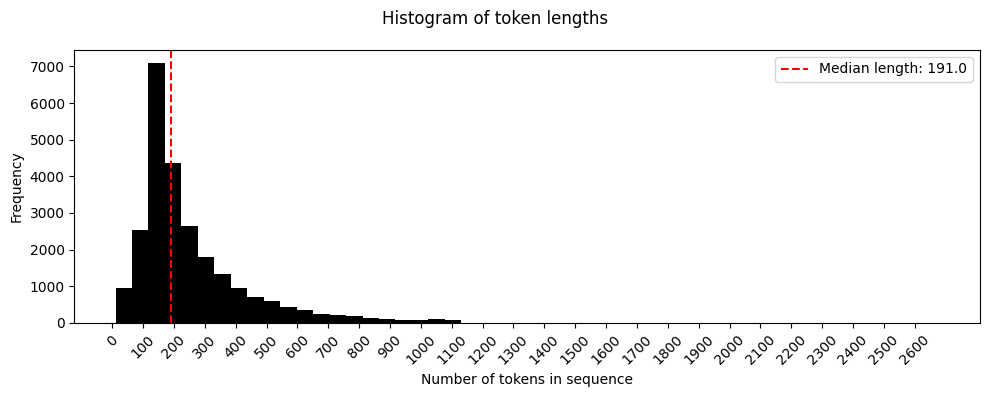

In [8]:
# Histogram of token lengths
token_lengths = [len(tokenizer.encode(text).ids) for text in dataset_train["text"]]
median_length = np.median(token_lengths)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_lengths, bins=50, color="black")
ax.set_xticks(np.arange(0, np.max(token_lengths) + 1, 100))
ax.tick_params(axis="x", labelrotation=45)
ax.set_xlabel("Number of tokens in sequence")
ax.set_ylabel("Frequency")
ax.axvline(median_length, color="red", linestyle="--", label=f"Median length: {median_length}")
ax.legend()
fig.suptitle("Histogram of token lengths")
fig.tight_layout()
plt.show()

### 1.4 Dataset and Data Loaders

To deal with sequences of different lengths, we implement a simple `IMDBDataset` class that pads the sequences to the same length using the `[PAD]` token, or truncates them if they exceed the maximum sequence length. We also prepend the `[CLS]` token to the input sequences.

In [9]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, pad_idx, cls_idx):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.cls_idx = cls_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text and prepend the [CLS] token
        tokenized_text = self.tokenizer.encode(text)
        token_ids = tokenized_text.ids
        token_ids = [self.cls_idx] + token_ids # add start


        # Pad or truncate the sequence to the maximum length
        if len(token_ids) < self.max_length:
            token_ids += [self.pad_idx] * (self.max_length - len(token_ids))
        else:
            token_ids = token_ids[:self.max_length]

        return torch.tensor(token_ids), torch.tensor(label)

We create some constants:

- `MAX_LENGTH`: the maximum sequence length
- `PAD_ID`: the ID of the `[PAD]` token
- `CLS_ID`: the ID of the `[CLS]` token
- `BATCH_SIZE`: the batch size
- `NUM_WORKERS`: the number of workers for data loading (set this to 0 if you are encountering issues with the DataLoader)

We also create the training and testing datasets and data loaders.

In [10]:
# Constants
MAX_LENGTH = 256
PAD_ID = tokenizer.token_to_id(PAD_TOKEN)
CLS_ID = tokenizer.token_to_id(CLS_TOKEN)
BATCH_SIZE = 64
NUM_WORKERS = 2

# Dataset instances
train_dataset = IMDBDataset(dataset_train["text"], dataset_train["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
val_dataset = IMDBDataset(dataset_val["text"], dataset_val["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
test_dataset = IMDBDataset(dataset_test["text"], dataset_test["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## 2. Model

### 2.1 Training Loop

We define a simple train function that takes `model` and trains it for `num_epochs` on `train_loader`. We give the `criterion` (loss function) and `optimizer` as arguments to the function. The train function also needs to know `pad_id`, the ID of the `[PAD]` token so we can generate the attention mask making sure the model does not attend to the padding tokens. After each epoch, we evaluate the model on `val_loader`.

In [11]:
def create_mask(sequences, pad_id):
    """
    Input shape of token sequences: (batch_size, seq_length)
    Output shape: (batch_size, seq_length) boolean mask with True where the padding tokens are located
    """
    # den funker men ser helt dust ut
    mask = (sequences == pad_id)

    return mask



def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, pad_id):
    #Extrem speedup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        correct, total = 0, 0
        for sequences, labels in (pbar := tqdm(train_loader)):

            sequences = sequences.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Clip gradients for stability
            optimizer.step()
            train_losses.append(loss.item())
            correct += ((outputs > 0.5) == labels).sum().item()
            total += labels.size(0)
            pbar.set_description(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Train Acc.: {correct / total:.4f}")

        # Validation
        #HUSK EVAL
        model.eval()
        val_losses = []
        correct, total = 0, 0
        with torch.no_grad():
            for sequences, labels in tqdm(val_loader):
                sequences = sequences.to(device)
                labels = labels.float().to(device)
                attention_mask = create_mask(sequences, pad_id)
                outputs = model(sequences, mask=attention_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                correct += ((outputs > 0.5) == labels).sum().item()
                total += labels.size(0)
        print(f"Epoch {epoch+1}, Val Loss: {np.mean(val_losses):.4f}, Val Acc.: {correct / total:.4f}")


### 2.2 Multi-Head Attention

We implement the multi-head attention mechanism. The multi-head attention mechanism consists of `num_heads` independent attention mechanisms. We concatenate the outputs of the different heads and project them back to the model's dimension. We use the scaled dot-product attention mechanism.

In [12]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        """
        Multihead attention module.
        Args:
            dim: Dimension of the input vectors
            num_heads: Number of attention heads
            dropout: Dropout rate for attention scores (default: 0.1)
        """
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads

        assert dim % num_heads == 0, f"Dimension {dim} must be divisible by num_heads {num_heads}"

        self.head_dim = dim // num_heads

        # TODO: Linear transformations for query, key, and value
        #straight up bare linear fc
        self.query = nn.Linear(self.dim, self.dim)
        self.key = nn.Linear(self.dim,self.dim)
        self.value = nn.Linear(self.dim,self.dim)

        # TODO: Output linear transformation
        self.out_proj = nn.Linear(self.dim,self.dim)

    #tror initen sitter.
    def forward(self, query, key, value, key_padding_mask):

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        batch_size, seq_length, _ = query.shape
        #Get correct shape
        def reshape_heads(x):
            return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        #Reshape q,k,v
        Q = reshape_heads(Q)
        K = reshape_heads(K)
        V = reshape_heads(V)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        #Apply mask
        if key_padding_mask is not None:
            attn_scores = attn_scores.masked_fill(key_padding_mask[:, None, None, :] == 1, float('-inf'))

        attn_probs = F.softmax(attn_scores, dim=-1)  # Normalize scores
        attn_output = torch.matmul(attn_probs, V)  # Apply attention to values

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.dim)
        output = self.out_proj(attn_output)  # Final linear layer

        return output


### 2.3 Encoder Block

We implement the encoder block, which consists of our multi-head attention layer followed by a feedforward neural network. We also add residual connections and layer normalizations as specified in the project description.

In [13]:
def mlp(dim, dropout=0.1):
    #Follows the instructions from project
    return nn.Sequential(
        nn.Linear(dim, 4*dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(4*dim, dim),
        nn.Dropout(dropout)
    )
class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.multihead= MultiheadAttention(dim, num_heads)
        self.mlp=  mlp(dim)
        self.layer_norm1 = nn.LayerNorm(dim)
        self.dropout1 =nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(dim)
        self.dropout2 =nn.Dropout(dropout)

    def forward(self, x, mask=None):
        skip= x
        x= self.layer_norm1(x)
        x= self.multihead.forward(x,x,x,mask)
        x = self.dropout1(x)
        x= x+skip #Add skip
        skip= x
        x= self.layer_norm2(x)
        x= self.mlp.forward(x)
        x = self.dropout2(x)
        x= x+skip #Add skip again
        return x




### 2.4 Model Specification

We specify our classifier model, which consists of an embedding layer, followed by `num_layers` encoder blocks. We use a linear layer to project the output of the last encoder block and apply sigmoid activation to get the final output.

We also define the positional encoding, which is added to the input embeddings to give the model information about the position of the tokens in the sequence.

In [14]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module: adds positional information to the input embeddings.
    """
    def __init__(self, embed_size, max_len):
        super().__init__()
        self.pe = torch.zeros(max_len, embed_size)
    def forward(self, x):
        self.pe = self.pe.to(x.device)
        x = x + self.pe[:x.size(1)]
        return x

class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, embedding_dim, num_heads, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)

        self.encoder = nn.ModuleList([EncoderBlock(embedding_dim, num_heads, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(embedding_dim, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        x = self.pos_encoder(x)  # Add positional encodings

        for encoder in self.encoder:
            x = encoder(x, mask=mask)

        x = x[:, 0, :]  # Take the first token's embedding (CLS token equivalent)

        return self.sigmoid(self.fc(x)).squeeze()


### 2.5 Training the Model

We can now train the model. It is recommended that you use the parameters provided in the cell below as they should work pretty good without requiring too much computational power.

Train the model for (at least) 3 epochs. Each epoch should take around 7 to 12 minutes on a modern CPU. If you are training on a laptop, make sure it is plugged in. Moreover, closing all other applications can also help. Take a well-deserved break while the model trains.

If you struggle with extremely long training times, you can do one or more of the following to speed up training:

- Increase `MIN_FREQUENCY` and re-train the tokenizer to reduce the vocabulary size.
- Use a subset of the training data.
- Reduce the number of epochs.
- Reduce the maximum sequence length.
- Experiment with `NUM_WORKERS` in the data loaders (optimal value is system-dependent).
- If you have a GPU, modify the training function above to use it.

Expect to observe a training accuracy above `0.60` halfway through the first epoch.

In [15]:
NUM_EPOCHS = 5
LR = 1e-3
WEIGHT_DECAY = 1e-3
EMBEDDING_DIM = 96
NUM_HEADS = 4
NUM_LAYERS = 3

model = SentimentTransformer(vocab_size=VOCAB_SIZE,
                             max_len=MAX_LENGTH,
                             embedding_dim=EMBEDDING_DIM,
                             num_heads=NUM_HEADS,
                             num_layers=NUM_LAYERS,
                             pad_idx=PAD_ID)

criterion = nn.BCELoss() # Model output should have sigmoid applied!
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")

train_model(model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=NUM_EPOCHS,
            pad_id=PAD_ID)

Number of parameters: 1295617


100%|██████████| 79/79 [00:02<00:00, 28.71it/s]


Epoch 1, Val Loss: 0.3987, Val Acc.: 0.8192


100%|██████████| 79/79 [00:02<00:00, 31.20it/s]


Epoch 2, Val Loss: 0.3540, Val Acc.: 0.8466


100%|██████████| 79/79 [00:03<00:00, 26.17it/s]


Epoch 3, Val Loss: 0.3683, Val Acc.: 0.8486


100%|██████████| 79/79 [00:02<00:00, 27.78it/s]


Epoch 4, Val Loss: 0.3785, Val Acc.: 0.8514


100%|██████████| 79/79 [00:03<00:00, 23.58it/s]

Epoch 5, Val Loss: 0.3909, Val Acc.: 0.8372


### 2.6 Evaluating the Model on Unseen Data

We evaluate the model on the test set and print the test accuracy.

In [16]:
def evaluate_model(model, test_loader, pad_id):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    correct, total = 0, 0
    tp,tn, fp, fn = 0, 0, 0, 0
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader):
            sequences = sequences.to(device)
            labels = labels.float().to(device)
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)
            predictions = (outputs > 0.5).float()
            for i in range(len(predictions)):
              if labels[i]==0:
                if predictions[i]:
                  fp+=1
                else:
                  tn+=1
              else:
                if predictions[i]:
                  tp+=1
                else:
                  fn+=1

            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total , [tp,tn, fp, fn]

accuracy, overview = evaluate_model(model, test_loader, PAD_ID)
print(f"Accuracy (test): {accuracy:.4f}")


100%|██████████| 313/313 [00:10<00:00, 29.05it/s]

Accuracy (test): 0.8416


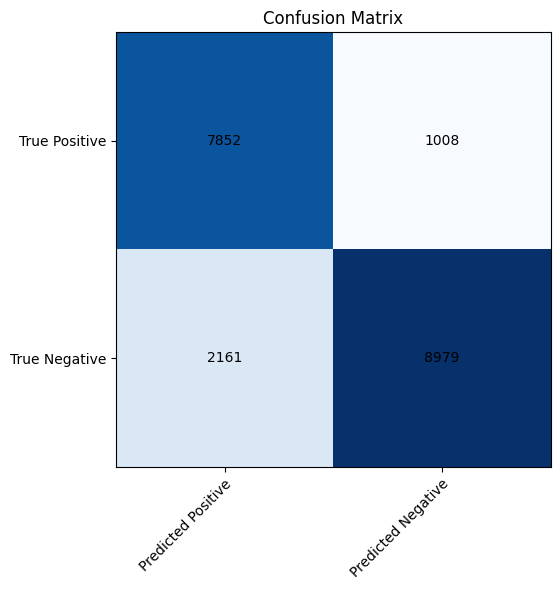

True Positive: 7852
False Positive: 1008
False Negative: 2161
True Negative: 8979


In [19]:

def plot_confusion_matrix(overview):
    tp, tn, fp, fn = overview
    cm = np.array([[tp, fp], [fn, tn]])
    labels = ["True Positive", "False Positive", "False Negative", "True Negative"]
    values = [tp, fp, fn, tn]
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(["Predicted Positive", "Predicted Negative"])
    ax.set_yticklabels(["True Positive", "True Negative"])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()
    for i, label in enumerate(labels):
        print(f"{label}: {values[i]}")

plot_confusion_matrix(overview)


### 2.7 Testing the Model on Custom Examples

For fun, we test the model on some custom examples from IMDb.

In [20]:
# Function to classify a single review
def classify_review(review, model, tokenizer, pad_idx, cls_idx, max_length):
    # TODO: Implement this function
    # Remember to set the model to evaluation mode, preprocess the review, tokenize it with [CLS] token prepended, pad/truncate and create a mask before passing it to the model
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    review = preprocess_text(review)

    tokenized_text = tokenizer.encode(review)
    token_ids = tokenized_text.ids
    token_ids = [cls_idx] + token_ids
    if len(token_ids) < max_length:
        token_ids += [pad_idx] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]
    sequences = torch.tensor([token_ids]).to(device)  # Create a tensor and move to device


    with torch.no_grad():
        sequences = sequences.to(device)

        attention_mask = create_mask(sequences, pad_idx)
        outputs = model(sequences, mask=attention_mask)

        sentiment = (outputs > 0.5).float()
        p = outputs.item()


    return sentiment, p



In [21]:
# TODO: Classify some reviews chosen by you
first=classify_review(review="This is some of the weirdest shit I have ever seen! Really impressed",model=model, tokenizer=
                tokenizer ,pad_idx=PAD_ID,cls_idx=CLS_ID,max_length=256)
second= classify_review(review="This is some of the weirdest shit I have ever seen! SUCKED BALLS",model=model, tokenizer=
                tokenizer ,pad_idx=PAD_ID,cls_idx=CLS_ID,max_length=256)
third =classify_review(review="Wow, I dont really know how to feel about this movie. Its not bad, but not good",model=model, tokenizer=
                tokenizer ,pad_idx=PAD_ID,cls_idx=CLS_ID,max_length=256)
fourth =classify_review(review="WORST MOVIE EVER! I will never watch it again, truly bad. Horrible movie",model=model, tokenizer=
                tokenizer ,pad_idx=PAD_ID,cls_idx=CLS_ID,max_length=256)

In [22]:
print(first)
print(second)
print(third)
print(fourth)




(tensor(1., device='cuda:0'), 0.9949809908866882)
(tensor(0., device='cuda:0'), 0.007921230047941208)
(tensor(0., device='cuda:0'), 0.039490144699811935)
(tensor(0., device='cuda:0'), 0.00028931640554219484)
